# What's up bitches, welcome to my Senior Thesis

Buckle up cause ur in for a wild ride

In [1]:
#import libraries
import numpy as np
import pandas as pd
import psycopg2

In [2]:
# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser,password = 'Harold67!')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

In [3]:
# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }

 ### Execute queries to load in tables from MIMIC-III Database stored on my local computer

In [4]:
admissions_query = query_schema+ """
SELECT subject_id, hadm_id, admittime, dischtime, deathtime
FROM admissions
"""

cptevents_query = query_schema + """
SELECT subject_id, hadm_id, chartdate, cpt_cd, cpt_number, cpt_suffix, description
FROM cptevents 
"""

patients_query = query_schema + """
SELECT *
FROM patients
"""


#execute queries and store tables in pandas dataframel
admissions_df = pd.read_sql_query(admissions_query, con)
cptevents_df = pd.read_sql_query(cptevents_query, con)
patients_df = pd.read_sql_query(patients_query, con)

In [5]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser,password = 'Harold67!')
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

# Modify first day labs code: 
# https://github.com/MIT-LCP/mimic-code/tree/master/etc/firstday
query = \
"""
WITH pvt AS (
  SELECT ie.subject_id, ie.hadm_id, ie.outtime, ie.icustay_id, le.charttime, ad.deathtime
  , CASE when ad.deathtime between ie.intime and ie.outtime THEN 1 ELSE 0 END AS mort_icu
  , CASE when ad.deathtime between ad.admittime and ad.dischtime THEN 1 ELSE 0 END AS mort_hosp
  -- here we assign labels to ITEMIDs
  -- this also fuses together multiple ITEMIDs containing the same data
  , CASE
        when le.itemid = 50868 then 'ANION GAP'
        when le.itemid = 50862 then 'ALBUMIN'
        when le.itemid = 50882 then 'BICARBONATE'
        when le.itemid = 50885 then 'BILIRUBIN'
        when le.itemid = 50912 then 'CREATININE'
        when le.itemid = 50806 then 'CHLORIDE'
        when le.itemid = 50902 then 'CHLORIDE'
        when itemid = 50809 then 'GLUCOSE'
        when itemid = 50931 then 'GLUCOSE'
        when itemid = 50810 then 'HEMATOCRIT'
        when itemid = 51221 then 'HEMATOCRIT'
        when itemid = 50811 then 'HEMOGLOBIN'
        when itemid = 51222 then 'HEMOGLOBIN'
        when itemid = 50813 then 'LACTATE'
        when itemid = 50960 then 'MAGNESIUM'
        when itemid = 50970 then 'PHOSPHATE'
        when itemid = 51265 then 'PLATELET'
        when itemid = 50822 then 'POTASSIUM'
        when itemid = 50971 then 'POTASSIUM'
        when itemid = 51275 then 'PTT'
        when itemid = 51237 then 'INR'
        when itemid = 51274 then 'PT'
        when itemid = 50824 then 'SODIUM'
        when itemid = 50983 then 'SODIUM'
        when itemid = 51006 then 'BUN'
        when itemid = 51300 then 'WBC'
        when itemid = 51301 then 'WBC'
      ELSE null
      END AS label
  , -- add in some sanity checks on the values
    -- the where clause below requires all valuenum to be > 0, 
    -- so these are only upper limit checks
    CASE
      when le.itemid = 50862 and le.valuenum >    10 then null -- g/dL 'ALBUMIN'
      when le.itemid = 50868 and le.valuenum > 10000 then null -- mEq/L 'ANION GAP'
      when le.itemid = 50882 and le.valuenum > 10000 then null -- mEq/L 'BICARBONATE'
      when le.itemid = 50885 and le.valuenum >   150 then null -- mg/dL 'BILIRUBIN'
      when le.itemid = 50806 and le.valuenum > 10000 then null -- mEq/L 'CHLORIDE'
      when le.itemid = 50902 and le.valuenum > 10000 then null -- mEq/L 'CHLORIDE'
      when le.itemid = 50912 and le.valuenum >   150 then null -- mg/dL 'CREATININE'
      when le.itemid = 50809 and le.valuenum > 10000 then null -- mg/dL 'GLUCOSE'
      when le.itemid = 50931 and le.valuenum > 10000 then null -- mg/dL 'GLUCOSE'
      when le.itemid = 50810 and le.valuenum >   100 then null -- % 'HEMATOCRIT'
      when le.itemid = 51221 and le.valuenum >   100 then null -- % 'HEMATOCRIT'
      when le.itemid = 50811 and le.valuenum >    50 then null -- g/dL 'HEMOGLOBIN'
      when le.itemid = 51222 and le.valuenum >    50 then null -- g/dL 'HEMOGLOBIN'
      when le.itemid = 50813 and le.valuenum >    50 then null -- mmol/L 'LACTATE'
      when le.itemid = 50960 and le.valuenum >    60 then null -- mmol/L 'MAGNESIUM'
      when le.itemid = 50970 and le.valuenum >    60 then null -- mg/dL 'PHOSPHATE'
      when le.itemid = 51265 and le.valuenum > 10000 then null -- K/uL 'PLATELET'
      when le.itemid = 50822 and le.valuenum >    30 then null -- mEq/L 'POTASSIUM'
      when le.itemid = 50971 and le.valuenum >    30 then null -- mEq/L 'POTASSIUM'
      when le.itemid = 51275 and le.valuenum >   150 then null -- sec 'PTT'
      when le.itemid = 51237 and le.valuenum >    50 then null -- 'INR'
      when le.itemid = 51274 and le.valuenum >   150 then null -- sec 'PT'
      when le.itemid = 50824 and le.valuenum >   200 then null -- mEq/L == mmol/L 'SODIUM'
      when le.itemid = 50983 and le.valuenum >   200 then null -- mEq/L == mmol/L 'SODIUM'
      when le.itemid = 51006 and le.valuenum >   300 then null -- 'BUN'
      when le.itemid = 51300 and le.valuenum >  1000 then null -- 'WBC'
      when le.itemid = 51301 and le.valuenum >  1000 then null -- 'WBC'
    ELSE le.valuenum
    END AS valuenum
  FROM icustays ie

  LEFT JOIN labevents le
    ON le.subject_id = ie.subject_id 
    AND le.hadm_id = ie.hadm_id
    AND le.charttime between (ie.intime - interval '6' hour) 
    AND (ie.intime + interval '1' day)
    AND le.itemid IN
    (
      -- comment is: LABEL | CATEGORY | FLUID | NUMBER OF ROWS IN LABEVENTS
      50868, -- ANION GAP | CHEMISTRY | BLOOD | 769895
      50862, -- ALBUMIN | CHEMISTRY | BLOOD | 146697
      50882, -- BICARBONATE | CHEMISTRY | BLOOD | 780733
      50885, -- BILIRUBIN, TOTAL | CHEMISTRY | BLOOD | 238277
      50912, -- CREATININE | CHEMISTRY | BLOOD | 797476
      50902, -- CHLORIDE | CHEMISTRY | BLOOD | 795568
      50806, -- CHLORIDE, WHOLE BLOOD | BLOOD GAS | BLOOD | 48187
      50931, -- GLUCOSE | CHEMISTRY | BLOOD | 748981
      50809, -- GLUCOSE | BLOOD GAS | BLOOD | 196734
      51221, -- HEMATOCRIT | HEMATOLOGY | BLOOD | 881846
      50810, -- HEMATOCRIT, CALCULATED | BLOOD GAS | BLOOD | 89715
      51222, -- HEMOGLOBIN | HEMATOLOGY | BLOOD | 752523
      50811, -- HEMOGLOBIN | BLOOD GAS | BLOOD | 89712
      50813, -- LACTATE | BLOOD GAS | BLOOD | 187124
      50960, -- MAGNESIUM | CHEMISTRY | BLOOD | 664191
      50970, -- PHOSPHATE | CHEMISTRY | BLOOD | 590524
      51265, -- PLATELET COUNT | HEMATOLOGY | BLOOD | 778444
      50971, -- POTASSIUM | CHEMISTRY | BLOOD | 845825
      50822, -- POTASSIUM, WHOLE BLOOD | BLOOD GAS | BLOOD | 192946
      51275, -- PTT | HEMATOLOGY | BLOOD | 474937
      51237, -- INR(PT) | HEMATOLOGY | BLOOD | 471183
      51274, -- PT | HEMATOLOGY | BLOOD | 469090
      50983, -- SODIUM | CHEMISTRY | BLOOD | 808489
      50824, -- SODIUM, WHOLE BLOOD | BLOOD GAS | BLOOD | 71503
      51006, -- UREA NITROGEN | CHEMISTRY | BLOOD | 791925
      51301, -- WHITE BLOOD CELLS | HEMATOLOGY | BLOOD | 753301
      51300  -- WBC COUNT | HEMATOLOGY | BLOOD | 2371
    )
    AND le.valuenum IS NOT null 
    AND le.valuenum > 0 -- lab values cannot be 0 and cannot be negative
    
    LEFT JOIN admissions ad
        ON ie.subject_id = ad.subject_id
    AND ie.hadm_id = ad.hadm_id
    
    -- WHERE ie.subject_id < 10000
    
),
ranked AS (
SELECT pvt.*, DENSE_RANK() OVER (PARTITION BY 
    pvt.subject_id, pvt.hadm_id,pvt.icustay_id,pvt.label ORDER BY pvt.charttime) as drank
FROM pvt
)
SELECT r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp
  , max(case when label = 'ANION GAP' then valuenum else null end) as ANIONGAP_1st
  , max(case when label = 'ALBUMIN' then valuenum else null end) as ALBUMIN_1st
  , max(case when label = 'BICARBONATE' then valuenum else null end) as BICARBONATE_1st
  , max(case when label = 'BILIRUBIN' then valuenum else null end) as BILIRUBIN_1st
  , max(case when label = 'CREATININE' then valuenum else null end) as CREATININE_1st
  , max(case when label = 'CHLORIDE' then valuenum else null end) as CHLORIDE_1st
  , max(case when label = 'GLUCOSE' then valuenum else null end) as GLUCOSE_1st
  , max(case when label = 'HEMATOCRIT' then valuenum else null end) as HEMATOCRIT_1st
  , max(case when label = 'HEMOGLOBIN' then valuenum else null end) as HEMOGLOBIN_1st
  , max(case when label = 'LACTATE' then valuenum else null end) as LACTATE_1st
  , max(case when label = 'MAGNESIUM' then valuenum else null end) as MAGNESIUM_1st
  , max(case when label = 'PHOSPHATE' then valuenum else null end) as PHOSPHATE_1st
  , max(case when label = 'PLATELET' then valuenum else null end) as PLATELET_1st
  , max(case when label = 'POTASSIUM' then valuenum else null end) as POTASSIUM_1st
  , max(case when label = 'PTT' then valuenum else null end) as PTT_1st
  , max(case when label = 'INR' then valuenum else null end) as INR_1st
  , max(case when label = 'PT' then valuenum else null end) as PT_1st
  , max(case when label = 'SODIUM' then valuenum else null end) as SODIUM_1st
  , max(case when label = 'BUN' then valuenum else null end) as BUN_1st
  , max(case when label = 'WBC' then valuenum else null end) as WBC_1st

FROM ranked r
WHERE r.drank = 1
GROUP BY r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp, r.drank
ORDER BY r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp, r.drank;
"""

data = pd.read_sql_query(query,con)

Implement preprocessing steps 

For the SVD implementations we will replace the nan values with an average and for the NMF implementations we will fill them with 0 (because NMF performs better on sparse matrices)

In [6]:
from sklearn import preprocessing
#We will use our threshold of max number of nan values at 7
lab_data = data.dropna(thresh=6)
#construct a lambda function to fill nan values of each column with that average
lab_data = lab_data.apply(lambda x: x.fillna(x.mean())) 

In [7]:
nmf_lab_data = data.apply(lambda x: x.fillna(0))
#construct lambda function to fill nan values with 0
nmf_lab_data = nmf_lab_data.drop(['subject_id','hadm_id','icustay_id'],axis =1)

In [51]:
#zero center lab data for sdd calculations
sdd_lab_data = lab_data.apply(lambda x: x.fillna(x.mean())) 
sdd_labMatrix = sdd_lab_data.values
sdd_labMatrix = preprocessing.scale(sdd_labMatrix)

I will add the procedures to the master dataframe and convert them according to icd9 codes

In [8]:
dicd_procedures_df = pd.read_csv("C:/Users/rachh/OneDrive/Documents/Senior Thesis/Mimic/D_ICD_PROCEDURES.csv")

In [9]:
dicd_procedures_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,264,851,Canthotomy,Canthotomy
1,265,852,Blepharorrhaphy,Blepharorrhaphy
2,266,859,Adjust lid position NEC,Other adjustment of lid position
3,267,861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
4,268,862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...


In [10]:
#convert the icd9 code and its keys into a dictionary that can be applied to a dataframe column 
subsection_dict = dicd_procedures_df.set_index('ICD9_CODE')['SHORT_TITLE'].to_dict()

In [11]:
procedures_df = pd.read_csv("C:/Users/rachh/Downloads/procedures.csv")

In [12]:
#apply dictionary
procedures_df['icd9_code'] = procedures_df['icd9_code'].map(subsection_dict)

#### D_CPT

In order to make use of the cpt_events table, it was necessary to convert the cpt_codes to their appropriate values. To do so I could use the d_cpt table in the MIMIC-III database. The codes were provided in sections and subsections, so the section ranges were parsed, converted to integers and then ranges, and stored in a range_array

In [13]:
#execute sql query to read in cpt events dictionary to understand cpt codes 
d_cpt_query = query_schema+ """
SELECT * 
FROM d_cpt
"""

d_cpt_df = pd.read_sql_query(d_cpt_query, con)
d_cpt_df.head()

,row_id,category,sectionrange,sectionheader,subsectionrange,subsectionheader,codesuffix,mincodeinsubsection,maxcodeinsubsection
0,1,1,99201-99499,Evaluation and management,99201-99216,Office/other outpatient services,None,99201,99216
1,2,1,99201-99499,Evaluation and management,99217-99220,Hospital observation services,None,99217,99220
2,3,1,99201-99499,Evaluation and management,99221-99239,Hospital inpatient services,None,99221,99239
3,4,1,99201-99499,Evaluation and management,99241-99255,Consultations,None,99241,99255
4,5,1,99201-99499,Evaluation and management,99261-99263,Follow-up inpatient consultations (deleted codes),None,99261,99263


In [14]:
#loop through values in sectionrange column
#entires are strings, so need to parse the strings with - and ; as delimitors, store the two strings, convert them to integers
#and store those as a range 
import re 
range_array = []

def deleteAlpha(string):
    newStr = ""
    for ch in string:
        print(ch)
        if (ch.isalpha()):
            'hey'
        else:
            newStr = newStr+ ch
    string = newStr
    return string

def convertParseStrToInt(strings,range_array):
    for i in range(0,len(strings),2):
        string1 = strings[i]
        string2 = strings[i+1]
        int1 = int(string1)
        int2 = int(string2)
        range_array.append(range(int1,int2))
        
i=0 
for entry in d_cpt_df['subsectionrange']:
    entry = str(entry)
    strings = re.split('[-;]', entry,flags=re.IGNORECASE)
    if (len(strings) == 2):
        string1 = strings[0]
        string2 = strings[1]
        try:
            int1 = int(string1)
            int2 = int(string2)
            range_array.append(range(int1,int2))
        except:
            string1 = deleteAlpha(string1)
            string2 = deleteAlpha(string2)
            int1 = int(string1.lstrip('0'))
            int2 = int(string2.lstrip('0'))
            range_array.append(range(int1,int2))
            
    if (len(strings) == 1):
        string1 = strings[0]
        try: 
            int1 = int(string1)
            range_array.append(range(int1,int1))
        except:
            string1 = deleteAlpha(string1)
            int1 = int(string1.lstrip('0'))
            range_array.append(range(int1,int1))
    i+=1


0
0
0
1
F
0
0
1
5
F
0
5
0
0
F
0
5
7
5
F
1
0
0
0
F
1
2
2
0
F
2
0
0
0
F
2
0
5
0
F
3
0
0
6
F
3
5
7
3
F
4
0
0
0
F
4
3
0
6
F
5
0
0
5
F
5
1
0
0
F
6
0
0
5
F
6
0
4
5
F
7
0
1
0
F
7
0
2
5
F
0
0
1
6
T
0
2
0
7
T
0
2
5
6
T
0
2
5
9
T


In [15]:
blah = ['1','2','3','4']
rando_array = []
def convertParseStrToInt(strings,range_array):
    for i in range(0,len(strings),2):
        string1 = strings[i]
        string2 = strings[i+1]
        int1 = int(string1)
        int2 = int(string2)
        range_array.append(range(int1,int2))

convertParseStrToInt(blah,rando_array)

In [16]:
d_cpt_df['ranges'] = range_array

In [17]:
#create dictionaries to apply to cpt_events table
subsection_dict = d_cpt_df.set_index('ranges')['subsectionheader'].to_dict()

In [18]:
#create subclass so that numbers within range keys can be converted to the correct output
class RangeDict(dict):
    def __getitem__(self, item):
        if type(item) != range: # or xrange in Python 2
            for key in self:
                if item in key:
                    return self[key]
        else:
            return super().__getitem__(item)

In [19]:
def checkkey(this_key,thisdict):
    for key in thisdict:
        if this_key in key:
            #print(thisdict[key])
            break

In [20]:
range_dict = RangeDict(subsection_dict)

In [21]:
#apply dictionary to cptevents_df
decoded_array = []
for i in range(len(cptevents_df)):
    current_value = cptevents_df.cpt_cd[i]
    try:
        current_value = int(current_value)
        decode = range_dict.__getitem__(current_value)
        decoded_array.append(decode)
    except: 
        current_value = deleteAlpha(current_value)
        current_value = int(current_value.lstrip('0'))
        decode = range_dict.__getitem__(current_value)
        decoded_array.append(decode)

G
0
2
7
2
0
0
5
0
T
S
2
9
0
0
G
0
3
6
4
S
2
0
8
3
G
0
1
2
1
G
0
3
6
4
S
2
0
8
3
0
0
5
0
T
G
0
3
6
4
0
2
5
8
T
0
2
5
7
T
0
2
5
7
T
0
2
5
8
T
0
2
5
6
T
G
0
3
6
4
0
2
5
7
T
0
2
5
6
T
0
2
5
7
T
G
0
3
6
4
0
2
5
6
T
G
0
2
7
2
0
2
5
7
T
G
0
3
6
4
S
2
9
0
0
G
0
2
7
2
G
0
2
7
2
G
0
2
7
2
0
2
5
6
T
0
2
5
8
T
0
2
5
6
T
0
2
5
6
T
0
0
7
8
T
0
0
7
9
T
0
0
8
0
T
0
0
8
1
T
0
2
5
6
T
G
0
3
6
4
G
0
0
0
2
0
2
5
6
T


In [22]:
#create procedure column in cptevents_df containing the values for the cpt_id codes 
cptevents_df['procedure'] = decoded_array

### Merging DataFrames

In order to apply matrix decompositions the data must be in one dataframe. The DataFrames were combined on the subject_id column - meaning that rows in each dataframe with the same subject_id were concatinated.

In [23]:
#join all of the dataframes together. I'm not sure whether or not I want to include procedures in the entire yet 
master_df = pd.merge(cptevents_df, admissions_df, on = 'subject_id')
master_df = pd.merge(master_df, patients_df, on = 'subject_id')
master_df = pd.merge(master_df, lab_data, on = 'subject_id')
master_df.head()

,subject_id,hadm_id_x,chartdate,cpt_cd,cpt_number,cpt_suffix,description,procedure,hadm_id_y,admittime,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,11743,129545,NaT,99232,99232.0,None,None,Hospital inpatient services,129545,2147-02-24 00:13:00,...,1.4,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9
1,11743,129545,NaT,99232,99232.0,None,None,Hospital inpatient services,129545,2147-02-24 00:13:00,...,1.4,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9
2,11743,129545,NaT,99232,99232.0,None,None,Hospital inpatient services,129545,2147-02-24 00:13:00,...,1.4,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9
3,11743,129545,NaT,99232,99232.0,None,None,Hospital inpatient services,129545,2147-02-24 00:13:00,...,1.4,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9
4,11743,129545,NaT,99223,99223.0,None,None,Hospital inpatient services,129545,2147-02-24 00:13:00,...,1.4,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9


In [24]:
#we will also delete the identifier columns from the lab data to have a solely numeric dataframe
lab_data = lab_data.drop(['subject_id','hadm_id','icustay_id'],axis=1)

Proceeding with exploratory data analysis, it will be vital to understand what each of the features in the  master_df MEAN.

- $\textbf{Subject_ID:}$ unique numeric identifier which specifies the patient
- $\textbf{chartdate:}$ the date at which a procedure occurred
- $\textbf{cpt_cd:}$ original cpt code
- $\textbf{cpt_number:}$ numeric version of cpt_cd
- $\textbf{cpt_suffix:}$ text suffix when cpt_cd contains non-numeric characters
- $\textbf{description:}$ when a cpt_cd corresponds to the respiratory cost center, description provides more information
- $\textbf{admittime:}$ date and time the patient was admitted to the hospital
- $\textbf{dischtime:}$ date and time patient was discharged
- $\textbf{deathtime:}$ time of in-hospital death (only present if patient died in hospital)
- $\textbf{row_id:}$ row id
- $\textbf{gender:}$ gender of patient 
- $\textbf{dob:}$ date of birth of patient
- $\textbf{dod:}$ date of death of patient
- $\textbf{dod_hosp:}$ date of death as recored in the hospital database
- $\textbf{dod_ssn:}$ date of death as recorded in social security database
- $\textbf{expire_flag:}$ indicates whether the patient died or not (includes deaths within and outside of hospital)

### Converting to Dummy Variables

In order to apply matrix decompositions to our dataframe we must convert the categorical variables into dummy variables

In [25]:
master_df=master_df.drop(['cpt_cd','cpt_suffix','cpt_number','cpt_suffix'],axis = 1)
master_df = pd.get_dummies(master_df, prefix=['description','procedure','gender'])

In [26]:
import time
from datetime import datetime as dt

In [27]:
#apply a lambda function to all columns w/ datetime type 
master_df['chartdate'] = master_df['chartdate'].apply(lambda x: (x-dt(1970,1,1)).total_seconds())
master_df['admittime'] = master_df['admittime'].apply(lambda x: (x-dt(1970,1,1)).total_seconds())
master_df['dischtime'] = master_df['dischtime'].apply(lambda x: (x-dt(1970,1,1)).total_seconds())
master_df['deathtime'] = master_df['deathtime'].apply(lambda x: (x-dt(1970,1,1)).total_seconds())
master_df['dob'] = master_df['dob'].apply(lambda x: (x-dt(1970,1,1)).total_seconds())
master_df['dod'] = master_df['dod'].apply(lambda x: (x-dt(1970,1,1)).total_seconds())
master_df['dod_hosp'] = master_df['dod_hosp'].apply(lambda x: (x-dt(1970,1,1)).total_seconds())
master_df['dod_ssn'] = master_df['dod_ssn'].apply(lambda x: (x-dt(1970,1,1)).total_seconds())

In [28]:
#for nmf calculations fill nan values with 0, for svd/sdd fill them with the average
master_df = master_df.apply(lambda x: x.fillna(x.mean())) 
nmf_master_df=master_df.fillna(value=0)

I need to drop my ID columns because these are numeric values that are simply identifiers - they have no actual numeric meaning.

I am going to remove the variables chartdate, deathtime, row_id, dod, dod_hosp, dod_ssn, expire_flag, icustay_id, mort_icu and all procedures except for ? maternity care and delivery to perform an analysis on the remaining variables 

In [29]:
cols = ['admittime', 'dischtime','dob','mort_hosp', 'aniongap_1st', 'albumin_1st',
       'bicarbonate_1st', 'bilirubin_1st', 'creatinine_1st', 'chloride_1st',
       'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'lactate_1st',
       'magnesium_1st', 'phosphate_1st', 'platelet_1st', 'potassium_1st',
       'ptt_1st', 'inr_1st', 'pt_1st', 'sodium_1st', 'bun_1st', 'wbc_1st','procedure_Maternity care and delivery']
maternity_df = master_df[cols]

In [30]:
nmf_maternity_df = nmf_master_df[cols]

In [31]:
maternity_matrix = maternity_df.values
nmf_maternity_matrix = nmf_maternity_df.values

In [33]:
master_matrix = master_df.values

In [32]:
nmf_master_matrix = nmf_master_df.values

Standardize lab data 

In [37]:
standardizedLab_df = lab_data.drop(['mort_icu','mort_hosp'],axis=1)
standardizedLab_matrix = standardizedLab_df.values

In [38]:
standardizedLab_matrix = preprocessing.scale(standardizedLab_matrix)

#### Visualizing Lab Data

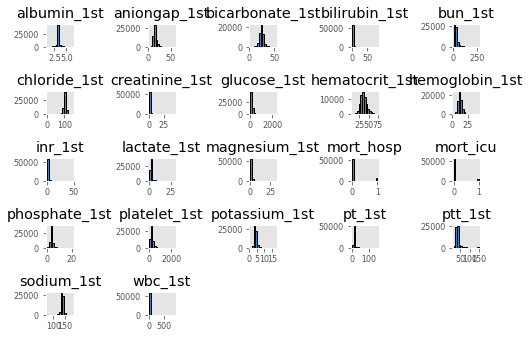

In [39]:
lab_data.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))  

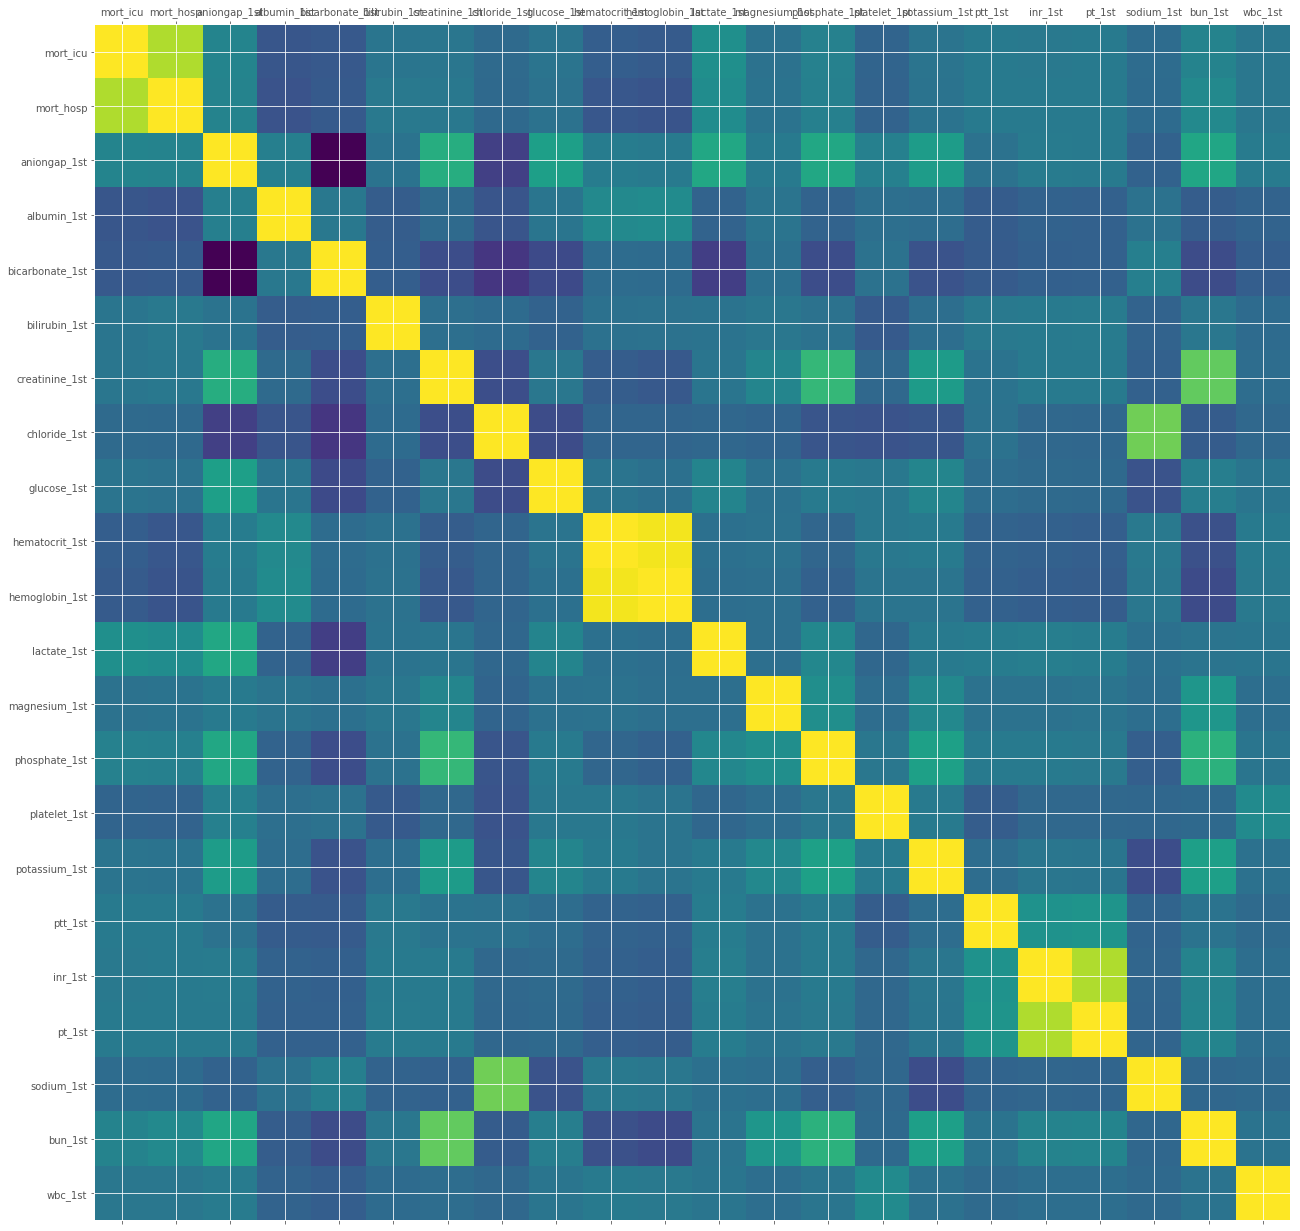

In [37]:
size = 22
corr = lab_data.corr()
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

In [38]:
rs = np.random.RandomState(0)
df = lab_data
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,mort_icu,mort_hosp,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,chloride_1st,glucose_1st,hematocrit_1st,hemoglobin_1st,lactate_1st,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
mort_icu,1,0.815767,0.15237,-0.128579,-0.108618,0.0591994,0.0651686,-0.0101639,0.0499564,-0.0827701,-0.0966828,0.227578,0.0426837,0.134372,-0.0413879,0.049917,0.0918822,0.0847867,0.0890386,0.0027948,0.147791,0.0708128
mort_hosp,0.815767,1,0.149762,-0.1484,-0.104565,0.0822397,0.0744905,-0.0116174,0.0382285,-0.124899,-0.139811,0.207469,0.0436169,0.128823,-0.0512271,0.048618,0.087179,0.0905852,0.0941316,0.000947788,0.181917,0.0718202
aniongap_1st,0.15237,0.149762,1,0.12248,-0.540392,0.0438366,0.421589,-0.249026,0.329633,0.10945,0.0901535,0.385596,0.0935485,0.382469,0.128816,0.309203,0.0395313,0.102624,0.0913043,-0.0581637,0.3736,0.0998914
albumin_1st,-0.128579,-0.1484,0.12248,1,0.0785717,-0.0852604,-0.0104422,-0.132026,0.0558991,0.185179,0.201244,-0.052081,0.0520842,-0.0483265,0.0194348,0.012947,-0.09172,-0.0580701,-0.0625813,0.0410742,-0.0869778,-0.0522158
bicarbonate_1st,-0.108618,-0.104565,-0.540392,0.0785717,1,-0.0787863,-0.175068,-0.298353,-0.191651,0.00254276,-0.000711835,-0.254042,0.0288571,-0.175447,0.0417916,-0.144995,-0.0962264,-0.0686378,-0.0610267,0.124694,-0.183654,-0.0827086
bilirubin_1st,0.0591994,0.0822397,0.0438366,-0.0852604,-0.0787863,1,0.02306,-0.000355571,-0.0555002,0.036404,0.0400873,0.0479151,0.0718658,0.0393829,-0.103386,0.0135616,0.081041,0.0915857,0.0997372,-0.0520742,0.0728457,0.000706269
creatinine_1st,0.0651686,0.0744905,0.421589,-0.0104422,-0.175068,0.02306,1,-0.169037,0.0697306,-0.084391,-0.109754,0.0584245,0.159046,0.485296,-0.019236,0.306911,0.0491494,0.0946611,0.0938363,-0.0642743,0.630089,0.00949983
chloride_1st,-0.0101639,-0.0116174,-0.249026,-0.132026,-0.298353,-0.000355571,-0.169037,1,-0.182785,-0.04093,-0.0405326,-0.026198,-0.0432599,-0.133749,-0.146266,-0.126476,0.0386662,-0.0224875,-0.0233449,0.663546,-0.0948314,-0.0202986
glucose_1st,0.0499564,0.0382285,0.329633,0.0558991,-0.191651,-0.0555002,0.0697306,-0.182785,1,0.0513288,0.0287114,0.156208,0.0367079,0.0889881,0.0744333,0.157788,0.0096491,-0.00650802,-0.0161514,-0.143634,0.118726,0.058373
hematocrit_1st,-0.0827701,-0.124899,0.10945,0.185179,0.00254276,0.036404,-0.084391,-0.04093,0.0513288,1,0.975179,0.030776,0.0399246,-0.0300679,0.0772597,0.0879547,-0.0528931,-0.0611306,-0.0720168,0.0851094,-0.160536,0.095395


### Applying SVD

In [68]:
#apply numpy SVD function to master matrix
master_U,master_s,master_V = np.linalg.svd(master_matrix,full_matrices = False)

MemoryError: 

In [41]:
#apply numpys SVD function (reduced version due to memory constraints)
redLab_U, redLab_s, redLab_v = np.linalg.svd(standardizedLab_matrix,full_matrices = False)

In [52]:
sddLab_U, sddLab_s, sddLab_v = np.linalg.svd(sdd_labMatrix,full_matrices = False)

In [ ]:
np.savetxt("C:/Users/rachh/Downloads/sddLabMatrix.csv", results, delimiter=",")

# Interpreting SVD Results

The size of each singular values (entries in s) tells you how much of the dataset's total variance is accounted for by each singular vector.

The results of SVD can give us a matrix with lower rank that is said to approximate the original matrix. To reconstruct a lower dimensional matrix we must first select the top k largest singular values in s.

### Selecting K 

* Plot singular values using a scree plot. A suitable cutoff point k is where the slope of the plot appears to flatten or where there is a detectable elbow or knee in the curve.
* Calculate the contribution of each singular value by calculating the sum $f_k$ and the entropy of the dataset. The magnitude of the entropy indicates how many dimensions need to be retained 

In [60]:
def calculateKnee(values):
    #get coordinates of all the points
    nPoints = len(values)
    allCoord = np.vstack((range(nPoints), values)).T
    #np.array([range(nPoints), values])

    # get the first point
    firstPoint = allCoord[0]
    # get vector between first and last point - this is the line
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))

    # find the distance from each point to the line:
    # vector between all points and first point
    vecFromFirst = allCoord - firstPoint

    # To calculate the distance to the line, we split vecFromFirst into two 
    # components, one that is parallel to the line and one that is perpendicular 
    # Then, we take the norm of the part that is perpendicular to the line and 
    # get the distance.
    # We find the vector parallel to the line by projecting vecFromFirst onto 
    # the line. The perpendicular vector is vecFromFirst - vecFromFirstParallel
    # We project vecFromFirst by taking the scalar product of the vector with 
    # the unit vector that points in the direction of the line (this gives us 
    # the length of the projection of vecFromFirst onto the line). If we 
    # multiply the scalar product by the unit vector, we have vecFromFirstParallel
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel

    # distance to line is the norm of vecToLine
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))

    # knee/elbow is the point with max distance value
    idxOfBestPoint = np.argmax(distToLine)

    print("Knee of the curve is at index =",idxOfBestPoint)
    return idxOfBestPoint

##### 1. Plot Singular Values with a Scree Plot

A scree plot is simply a scatter plot in which the magnitudes of the singular values are plotted in order.

In [40]:
import matplotlib
import matplotlib.pyplot as plt

Master Matrix Plotting

In [41]:
master_matrix.shape

(7075598, 93)

Text(0, 0.5, 'Eigenvalue')

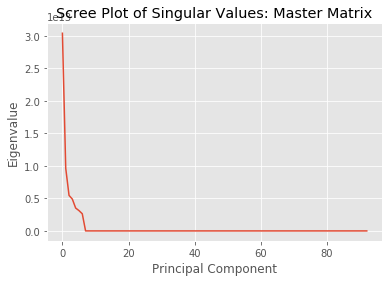

In [42]:
plt.plot(range(0,93),master_s)
plt.title('Scree Plot of Singular Values: Master Matrix')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

In [43]:
calculateKnee(master_s)

Knee of the curve is at index = 7


7

Wow! Using the screen plot, we can suggest that the k value should be at minumu less than 10.

Lab Data Plotting

Text(0, 0.5, 'Eigenvalue')

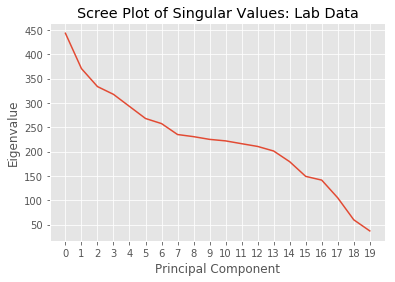

In [44]:
plt.plot(range(0,20),redLab_s)
plt.title('Scree Plot of Singular Values: Lab Data')
plt.xticks(range(0,20))
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

In [45]:
calculateKnee(redLab_s)

Knee of the curve is at index = 5


5

Text(0, 0.5, 'Eigenvalue')

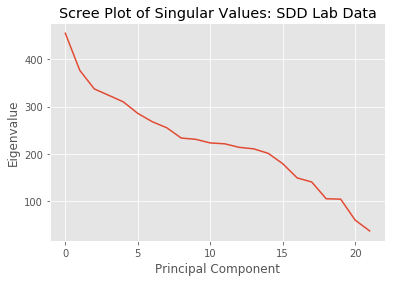

In [58]:
plt.plot(range(0,22),sddLab_s)
plt.title('Scree Plot of Singular Values: SDD Lab Data')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

In [61]:
calculateKnee(sddLab_s)

Knee of the curve is at index = 2


2

For this data, the scree plot indicates that a k value of around 5 should be fine.

##### 2. Calculate contribution of each value using $f_k$ and the entropy of the dataset. 

$f_k = s_k^2/\sum_{i=1}^rs_i^2$ and $entropy = -1/\log(r)\sum_{k=1}^rf_k\log(f_k)$

In [46]:
import math

Master Matrix Entropy Calculations

In [47]:
#declare empty list to contain f_k values
f_k_list = []
s_2 = []

for value in master_s:
    s_2.append(value**2)

s_i_sum = np.sum(s_2)
for i in range(69):
    s_k2 = s[i]**2
    f_k = s_k2/s_i_sum
    f_k_list.append(f_k)
    
log = -1*math.log(69,10)
print(log)
f_k_sum = 0
for i in range(69):
    f_k = f_k_list[i] 
    log_value = math.log(f_k,10)
    f_k_sum = f_k * log_value

print(log)
print(f_k_sum)
print("F_k values: ",f_k_list)
print("Entropy: ", entropy)

NameError: name 's' is not defined

These results are hard to make sense of, going forward - we will use the scree plot approach. Lets run with a working value of $k=9$ to be on the safe side.

Lab Data Entropy Calculations

In [ ]:
#declare empty list to contain f_k values
f_k_list = []
s_2 = []

for value in redLab_s:
    s_2.append(value**2)

s_i_sum = np.sum(s_2)
for i in range(22):
    s_k2 = redLab_s[i]**2
    f_k = s_k2/s_i_sum
    f_k_list.append(f_k)
    
log = -1*math.log(22,10)
print(log)
f_k_sum = 0
for i in range(22):
    f_k = f_k_list[i] 
    log_value = math.log(f_k,10)
    f_k_sum = f_k * log_value

print(log)
print(f_k_sum)
print("F_k values: ",f_k_list)
print("Entropy: ", entropy)

## Approximate matrix B for original matrix 

In [ ]:
#Extract first k values of sigma array
sigma_k = []
for i in range(9):
    sigma_k.append(master_s[i])


We can use sklearn's TruncatedSVD function to compute the SVD and compute the new approximated matrix. We can use this matrix to perform clustering algorithms in a lower dimensional space.

In [64]:
from sklearn.decomposition import TruncatedSVD

In [63]:
svd = TruncatedSVD(n_components = 7)
svd.fit(master_matrix)
results = svd.transform(master_matrix)

MemoryError: 

Export approximated matrix and store in .csv file

In [ ]:
np.savetxt("C:/Users/rachh/Downloads/master_matrix.csv", results, delimiter=",")

In [ ]:
matrix_transformed = svd.fit_transform(master_matrix)

Lab Clean Data Truncated SVD

In [ ]:
lab_svd = TruncatedSVD(n_components = 5)
lab_svd.fit(standardizedLab_matrix)
results = lab_svd.transform(standardizedLab_matrix)
print(results)

In [66]:
sdd_lab_svd = TruncatedSVD(n_components = 2)
sdd_lab_svd.fit(sdd_labMatrix)
sddLab_results = sdd_lab_svd.transform(sdd_labMatrix)

In [67]:
np.savetxt("C:/Users/rachh/Downloads/sdd_lab_svd.csv",sddLab_results)

### Clustering

In [ ]:
#import Kmeans package from sklearn 
from sklearn.cluster import KMeans 

In [ ]:
clusters = 20
  
kmeans = KMeans(n_clusters = clusters) 
kmeans.fit(results) 
  
print(kmeans.labels_)

In [ ]:
kmeans.labels_

In [ ]:
kmeans.inertia_

In [ ]:
#generate elbow plot
from scipy import cluster
cluster_array = [cluster.vq.kmeans(results, i) for i in range(1,10)]

plt.plot([var for (cent,var) in cluster_array])
plt.show()

In [ ]:
truncatedLab_df = pd.DataFrame(results)

In [ ]:
#K means Clustering 
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(truncatedLab_df, 2)
kmeans = pd.DataFrame(clust_labels)
truncatedLab_df.insert((truncatedLab_df.shape[1]),'kmeans',kmeans)

In [ ]:
truncatedLab_df.head()

In [ ]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(truncatedLab_df[0],truncatedLab_df[1],
                     c=kmeans[0],s=50)
plt.colorbar(scatter)
plt.show()

In [ ]:
reducedLab_df = pd.DataFrame(data = results,)

In [ ]:
reducedLab_df.head()

In [ ]:
reducedLab_df['mort_icu'] = clean_data['mort_icu'].values
reducedLab_df['mort_hosp'] = clean_data['mort_hosp'].values

In [ ]:
reducedLab_df.head()

In [ ]:
df = clean_data
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
df = truncatedLab_df
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
#next steps - delete mortality results from original dataframe and normalize values 

In [ ]:
#run SDD on truncated matrix produced by SVD - the logic behind this is that the SVD is denoising the matrix so that the 
#SVD can better detect the structure within it 
#labels from early columns of X can be used as labels for the clusters that the SDD finds 

In [ ]:
#for nmf we don't want to replace missing values, can accept sparse matrices as input 

### Implementing NMF

Now we will implement the NMF algorithms on the respective datasets 

In [70]:
from sklearn.decomposition import NMF

Determine number of components for NMF lab data

In [ ]:
nmf_lab_matrix = nmf_lab_data.values
U,s,V = np.linalg.svd(nmf_lab_matrix,full_matrices = False)

In [ ]:
nmf_lab_matrix.shape

In [ ]:
plt.plot(range(0,22),s)
plt.title('Scree Plot of Singular Values: NMF Lab Data')
plt.xticks(range(0,22))
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

In [ ]:
calculateKnee(s)

In [ ]:
model = NMF(n_components=3, init='random', random_state=0)
W = model.fit_transform(nmf_lab_matrix)
H = model.components_

In [ ]:
reduced_lab = W @ H 

In [ ]:
reduced_lab.shape

### Maternity and Ventilation Analysis

I will conduct the same analysis on my new dataset

In [ ]:
maternity

In [48]:
#apply numpy SVD function to master matrix
maternity_U,maternity_s,maternity_V = np.linalg.svd(maternity_matrix,full_matrices = False)

Text(0, 0.5, 'Eigenvalue')

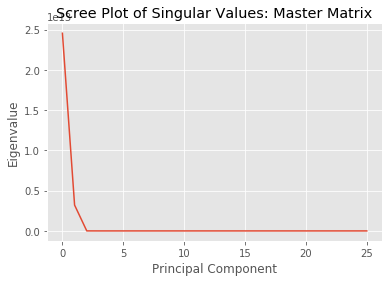

In [50]:
plt.plot(range(0,26),maternity_s)
plt.title('Scree Plot of Singular Values: Master Matrix')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

In [51]:
calculateKnee(maternity_s)

Knee of the curve is at index = 2


2

In [52]:
from sklearn.decomposition import TruncatedSVD

In [53]:
maternity_svd = TruncatedSVD(n_components = 2)
maternity_svd.fit(maternity_matrix)
matSVD_results = maternity_svd.transform(maternity_matrix)

In [54]:
#import Kmeans package from sklearn 
from sklearn.cluster import KMeans
matSVD_df = pd.DataFrame(matSVD_results)
#K means Clustering 
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(matSVD_df, 2)
kmeans = pd.DataFrame(clust_labels)
matSVD_df.insert((matSVD_df.shape[1]),'kmeans',kmeans)

In [59]:
matSVD_df.to_csv("C:/Users/rachh/Downloads/maternitySVD.csv")

In [56]:
matSVD_matrix = matSVD_df.values
np.savetxt("C:/Users/rachh/Downloads/maternitySVD.csv", matSVD_matrix, delimiter=",")

Now that we have clustered the SVD results, we will perform NMF on the maternity dataframe and see how our results differ

In [46]:
maternity_df.head()

,admittime,dischtime,dob,mort_hosp,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,chloride_1st,...,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st,procedure_Maternity care and delivery
0,5.590254e+09,5.592113e+09,3.041712e+09,0,11.0,3.177853,23.0,2.187562,0.8,109.0,...,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9,0
1,5.590254e+09,5.592113e+09,3.041712e+09,0,11.0,3.177853,23.0,2.187562,0.8,109.0,...,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9,0
2,5.590254e+09,5.592113e+09,3.041712e+09,0,11.0,3.177853,23.0,2.187562,0.8,109.0,...,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9,0
3,5.590254e+09,5.592113e+09,3.041712e+09,0,11.0,3.177853,23.0,2.187562,0.8,109.0,...,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9,0
4,5.590254e+09,5.592113e+09,3.041712e+09,0,11.0,3.177853,23.0,2.187562,0.8,109.0,...,3.7,376.0,4.0,32.9,1.4,14.3,139.0,18.0,9.9,0


In [55]:
#count number of negative entries in each column on mat matrix
sum(n<0 for n in maternity_matrix)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [54]:
#remove the negative values in the third column of the maternity_matrix because NMF can only work with nonnegative entries 
maternity_matrix = np.delete(maternity_matrix,2,1)

In [56]:
from sklearn.decomposition import NMF
mat_model = NMF(n_components=2)
mat_W = mat_model.fit_transform(maternity_matrix)
mat_H = mat_model.components_

In [57]:
matNMF = mat_W @ mat_H
matNMF_df = pd.DataFrame(matNMF)

In [60]:
#perform clustering 
#import Kmeans package from sklearn 
from sklearn.cluster import KMeans
#K m eans Clustering 
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(matNMF_df, 2)
kmeans = pd.DataFrame(clust_labels)
matNMF_df.insert((matNMF_df.shape[1]),'kmeans',kmeans)

In [61]:
matNMF_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,kmeans
0,5.590254e+09,5.592113e+09,0.079205,15.994334,3.020709,23.100505,1.93097,2.931576,96.795777,167.655273,...,233.238688,4.315071,36.117887,1.592941,16.456849,131.333017,34.462123,10.736579,0.000005,0
1,5.590254e+09,5.592113e+09,0.079205,15.994334,3.020709,23.100505,1.93097,2.931576,96.795777,167.655273,...,233.238688,4.315071,36.117887,1.592941,16.456849,131.333017,34.462123,10.736579,0.000005,0
2,5.590254e+09,5.592113e+09,0.079205,15.994334,3.020709,23.100505,1.93097,2.931576,96.795777,167.655273,...,233.238688,4.315071,36.117887,1.592941,16.456849,131.333017,34.462123,10.736579,0.000005,0
3,5.590254e+09,5.592113e+09,0.079205,15.994334,3.020709,23.100505,1.93097,2.931576,96.795777,167.655273,...,233.238688,4.315071,36.117887,1.592941,16.456849,131.333017,34.462123,10.736579,0.000005,0
4,5.590254e+09,5.592113e+09,0.079205,15.994334,3.020709,23.100505,1.93097,2.931576,96.795777,167.655273,...,233.238688,4.315071,36.117887,1.592941,16.456849,131.333017,34.462123,10.736579,0.000005,0


In [62]:
matNMF_df.to_csv("C:/Users/rachh/Downloads/maternityNMF.csv")

#### Produce Parallel Coordinate plots 

First we will plot a simple parallel coordinate plot using the matplotlib and pandas tools plotting libraries

In [ ]:
# libraries
import pandas
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates
 
# Take the iris dataset
import seaborn as sns

 
# Make the plot
parallel_coordinates(matSVD_df, 'kmeans', colormap=plt.get_cmap("Set2"))
plt.show()

## NMF and SVD Functions 

In [81]:
def computeTruncatedSVD(A):
    #apply numpy SVD function to input matrix
    k = calculateK(A)
    svd = TruncatedSVD(n_components = k)
    svd.fit(A)
    results = svd.transform(A)
    return results

def calculateK(A):
    #compute basic svd to find K value
    U,s,V = np.linalg.svd(A,full_matrices = False)
    k = calculateKnee(s)
    return k

In [71]:
from sklearn.decomposition import NMF

In [74]:
def computeNMF(A):
   #apply sklearn NMF function to input matrix
    k = calculateK(A)
    mat_model = NMF(n_components=k)
    mat_W = mat_model.fit_transform(A)
    mat_H = mat_model.components_
    return mat_W @ mat_H

Lab Data Calculations

In [76]:
labMatrix = lab_data.values
nmf_labMatrix = nmf_lab_data.values
sdd_labMatrix = sdd_lab_data.values

In [82]:
svdLab_results = computeTruncatedSVD(labMatrix)
sddLab_results = computeTruncatedSVD(sdd_labMatrix)
nmfLab_results = computeNMF(nmf_labMatrix)

svdLab_resultsDF = pd.DataFrame(svdLab_results)
sddLab_resultsDF = pd.DataFrame(sddLab_results)
nmfLab_resultsDF = pd.DataFrame(nmfLab_results)

svdLab_resultsDF.to_csv("C:/Users/rachh/OneDrive/Documents/Senior Thesis/svdLab_results.csv")
sddLab_resultsDF.to_csv("C:/Users/rachh/OneDrive/Documents/Senior Thesis/sddLab_results.csv")
nmfLab_resultsDF.to_csv("C:/Users/rachh/OneDrive/Documents/Senior Thesis/nmfLab_results.csv")

Knee of the curve is at index = 3
Knee of the curve is at index = 3
Knee of the curve is at index = 3


Master Matrix Calculations

In [83]:
mmSVD_results = computeTruncatedSVD(master_matrix)
mmNMF_results = computeNMF(master_matrix)

mmSVD_resultsDF = pd.DataFrame(mmSVD_results)
mmNMF_resultsDF = pd.DataFrame(mmNMF_results)

mmSVD_resultsDF.to_csv("C:/Users/rachh/OneDrive/Documents/Senior Thesis/mmSVD_results.csv")
mmNMF_resultsDF.to_csv("C:/Users/rachh/OneDrive/Documents/Senior Thesis/mmNMF_results.csv")

MemoryError: 